# **Importing and Installing dependencies**

In [2]:
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import spacy
import re
import pickle
import numpy as np
import gensim.downloader
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.model_selection import IterativeStratification
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
path = '/content/drive/MyDrive/Text Mining Project/'
with open(path+'animelist_categorized.pkl', 'rb') as f:
    anime_df = pickle.load(f)

In [24]:
anime_df = anime_df[['Name', 'Genres','Synopsis','Producers','Studios']]

Let us consider only the animes with a non null synopsis for the training of the models.



In [25]:
anime_df = anime_df[anime_df['Synopsis'].notnull()]

# **Text Classification**

## **Data Preprocessing**

We create a new *text* column in the dataframe that includes the anime name, producers, studios, and synopsis.

In [26]:
anime_df['text'] = anime_df['Name'] + ' ' + anime_df['Synopsis']

In [27]:
def concat_text(row):

  if not isinstance(row['Producers'], float):
    row['text'] = row['text'] + ' ' + row['Producers']

  if not isinstance(row['Studios'], float):
    row['text'] = row['text'] + ' ' + row['Studios']

  return row

anime_df = anime_df.apply(concat_text, axis = 1)

In [28]:
anime_df.head()

,Name,Genres,Synopsis,Producers,Studios,text
0,Cowboy Bebop,"[Fantasy and Supernatural, Action and Adventure]","Crime is timeless. By the year 2071, humanity ...",Bandai Visual,Sunrise,Cowboy Bebop Crime is timeless. By the year 20...
1,Cowboy Bebop: Tengoku no Tobira,"[Fantasy and Supernatural, Action and Adventure]","Another day, another bounty—such is the life o...","Sunrise, Bandai Visual",Bones,"Cowboy Bebop: Tengoku no Tobira Another day, a..."
2,Trigun,"[Fantasy and Supernatural, Action and Adventure]","Vash the Stampede is the man with a $$60,000,0...",Victor Entertainment,Madhouse,Trigun Vash the Stampede is the man with a $$6...
3,Witch Hunter Robin,"[Drama and Mistery, Action and Adventure, Fant...",Robin Sena is a powerful craft user drafted in...,"Bandai Visual, Dentsu, Victor Entertainment, T...",Sunrise,Witch Hunter Robin Robin Sena is a powerful cr...
4,Bouken Ou Beet,"[Fantasy and Supernatural, Action and Adventure]",It is the dark century and the people are suff...,"TV Tokyo, Dentsu",Toei Animation,Bouken Ou Beet It is the dark century and the ...


We clean and process the *text* column in order to training and testing the models.

In [29]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
stop_words = set(nlp.Defaults.stop_words)
stop_words.add('new')
stop_words.add('world')
stop_words.add('find')
stop_words.add('year')
stop_words.add('life')

In [30]:
def clean_text(text):
  text = text.replace('\n',' ') #remove newlines
  text = text.lower() #lowercase
  text = re.sub(r"\([Ss]ource: [A-Za-z0-9]*\)", "", text) #remove the source of the synopsis
  text = re.sub(r"[^a-z\s]+"," ",text) #remove puntuaction and symbols
  text = " ".join(re.split("\s+", text, flags=re.UNICODE)) #remove multiple whitespaces
  text = re.sub(r'\b\w\b', ' ', text) #remove single letters
  return text

def preprocess_text(text):
  #lemmatize
  doc = nlp(text)
  text = " ".join([token.lemma_ for token in doc])
  text = text.split(' ')
  #remove stopwords
  lst=[]
  for token in text:
    if token not in stop_words:
        lst.append(token)
  text = " ".join([word for word in lst])
  return text

In [31]:
anime_df['cleaned_synopsis'] = anime_df['text'].apply(lambda x: clean_text(x))

In [32]:
anime_df['preprocessed_synopsis'] = anime_df['cleaned_synopsis'].apply(lambda x: preprocess_text(x))

In [33]:
anime_df['preprocessed_synopsis'] = anime_df['preprocessed_synopsis'].apply(lambda x: clean_text(x))

In [34]:
newlines = 0
tabs = 0
two_tabs = 0
tab_newline = 0
whitespaces = 0
for text in anime_df['preprocessed_synopsis']:
  newlines += text.count('\n\n')
  tabs += text.count('\t')
  two_tabs += text.count('\t\t')
  tab_newline += text.count('\n\t')
  whitespaces += text.count('  ')
print("Number of 2 newlines", newlines)
print("Number of tabs", tabs)
print("Number of 2 tabs", two_tabs)
print("Number of tab and newline", tab_newline)
print("Number whitespaces", whitespaces)

Number of 2 newlines 0
Number of tabs 0
Number of 2 tabs 0
Number of tab and newline 0
Number whitespaces 142


In [35]:
anime_df['preprocessed_synopsis'] = anime_df['preprocessed_synopsis'].apply(lambda x: clean_text(x))

In [36]:
anime_df.head()

,Name,Genres,Synopsis,Producers,Studios,text,cleaned_synopsis,preprocessed_synopsis
0,Cowboy Bebop,"[Fantasy and Supernatural, Action and Adventure]","Crime is timeless. By the year 2071, humanity ...",Bandai Visual,Sunrise,Cowboy Bebop Crime is timeless. By the year 20...,cowboy bebop crime is timeless by the year hum...,cowboy bebop crime timeless humanity expand ga...
1,Cowboy Bebop: Tengoku no Tobira,"[Fantasy and Supernatural, Action and Adventure]","Another day, another bounty—such is the life o...","Sunrise, Bandai Visual",Bones,"Cowboy Bebop: Tengoku no Tobira Another day, a...",cowboy bebop tengoku no tobira another day ano...,cowboy bebop tengoku tobira day bounty unlucky...
2,Trigun,"[Fantasy and Supernatural, Action and Adventure]","Vash the Stampede is the man with a $$60,000,0...",Victor Entertainment,Madhouse,Trigun Vash the Stampede is the man with a $$6...,trigun vash the stampede is the man with bou...,trigun vash stampede man bounty head reason me...
3,Witch Hunter Robin,"[Drama and Mistery, Action and Adventure, Fant...",Robin Sena is a powerful craft user drafted in...,"Bandai Visual, Dentsu, Victor Entertainment, T...",Sunrise,Witch Hunter Robin Robin Sena is a powerful cr...,witch hunter robin robin sena is powerful cr...,witch hunter robin robin sena powerful craft u...
4,Bouken Ou Beet,"[Fantasy and Supernatural, Action and Adventure]",It is the dark century and the people are suff...,"TV Tokyo, Dentsu",Toei Animation,Bouken Ou Beet It is the dark century and the ...,bouken ou beet it is the dark century and the ...,bouken ou beet dark century people suffer rule...


We consider only the animes whose genres is defined, in order to train and test the models.

In [37]:
anime_df_genre = anime_df[anime_df['Genres'].notnull()]

In [38]:
anime_df_genre.head()

,Name,Genres,Synopsis,Producers,Studios,text,cleaned_synopsis,preprocessed_synopsis
0,Cowboy Bebop,"[Fantasy and Supernatural, Action and Adventure]","Crime is timeless. By the year 2071, humanity ...",Bandai Visual,Sunrise,Cowboy Bebop Crime is timeless. By the year 20...,cowboy bebop crime is timeless by the year hum...,cowboy bebop crime timeless humanity expand ga...
1,Cowboy Bebop: Tengoku no Tobira,"[Fantasy and Supernatural, Action and Adventure]","Another day, another bounty—such is the life o...","Sunrise, Bandai Visual",Bones,"Cowboy Bebop: Tengoku no Tobira Another day, a...",cowboy bebop tengoku no tobira another day ano...,cowboy bebop tengoku tobira day bounty unlucky...
2,Trigun,"[Fantasy and Supernatural, Action and Adventure]","Vash the Stampede is the man with a $$60,000,0...",Victor Entertainment,Madhouse,Trigun Vash the Stampede is the man with a $$6...,trigun vash the stampede is the man with bou...,trigun vash stampede man bounty head reason me...
3,Witch Hunter Robin,"[Drama and Mistery, Action and Adventure, Fant...",Robin Sena is a powerful craft user drafted in...,"Bandai Visual, Dentsu, Victor Entertainment, T...",Sunrise,Witch Hunter Robin Robin Sena is a powerful cr...,witch hunter robin robin sena is powerful cr...,witch hunter robin robin sena powerful craft u...
4,Bouken Ou Beet,"[Fantasy and Supernatural, Action and Adventure]",It is the dark century and the people are suff...,"TV Tokyo, Dentsu",Toei Animation,Bouken Ou Beet It is the dark century and the ...,bouken ou beet it is the dark century and the ...,bouken ou beet dark century people suffer rule...


## **Training and Testing**

Since this is a multilabel classification problem, we have to instantiate a *MultiLabelBinarizer* for one-hot encoding of the labels.

We fit the binarizer on the *Genres* column.

In [39]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(anime_df_genre['Genres'])

MultiLabelBinarizer()

In [40]:
y = multilabel_binarizer.transform(anime_df_genre['Genres'])

We divide the dataset in train (77%) and test set (33%).

In [41]:
X_train, X_test, y_train, y_test = train_test_split(anime_df_genre['preprocessed_synopsis'],
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42)

For the word embedding, we consider a *TF-IDF Vectorizer*. Moreover, we do not consider the words that appear in less than 1% of the documents and more than 99% of the document; we also consider unigrams and bigrams.

In [42]:
vectorizer = TfidfVectorizer(max_features = 10000, min_df = 0.01, max_df = 0.99, ngram_range=(1,2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [43]:
X_train_vectorized.shape

(6204, 1077)

## **Hyperparameter Optimization**

We consider four classifiers:
* *Support Vector Machine*
* *Logistic Regression*
* *Random Forest*
* *Naive Bayes*

We first take a step of hyperparameters optimization of the classifiers to figure out which are the best hyperparameters to use in our case.

#### **Support Vector Machine**

In [ ]:
param_grid_svm = {'estimator__C' : [1,10,100],
          'estimator__gamma': [0.001, 0.1, 1.0]}

clf = SVC()
multi_clf = MultiOutputClassifier(clf)
grid_search = GridSearchCV(multi_clf, param_grid_svm, cv=2, scoring = 'f1_micro')
grid_search.fit(X_train_vectorized, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best parameters combination for SVM:')
print("Best hyperparameters:", best_params)
print("Best F1 score:", best_score)

Best parameters combination for SVM:
Best hyperparameters: {'estimator__C': 100, 'estimator__gamma': 1.0}
Best F1 score: 0.6262660532796807


#### **Random Forest**

In [ ]:
param_grid_rf = {'estimator__n_estimators': [100, 300, 500],
          'estimator__criterion': ['gini', 'entropy', 'log_loss']}

clf = RandomForestClassifier()
multi_clf = MultiOutputClassifier(clf)
grid_search = GridSearchCV(multi_clf, param_grid_rf, cv = 2, scoring = 'f1_micro')
grid_search.fit(X_train_vectorized, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best parameters combination for RF:')
print("Best hyperparameters:", best_params)
print("Best F1 Score:", best_score)

Best parameters combination for RF:
Best hyperparameters: {'estimator__criterion': 'gini', 'estimator__n_estimators': 300}
Best F1 Score: 0.610039883867562


#### **Logistic Regression**

In [ ]:
param_grid_lr = {'estimator__penalty': ['l1', 'l2', 'elasticnet'],
          'estimator__C': [10,50,100]}

clf = LogisticRegression(solver = 'saga', max_iter=1000, tol = 1e-3)
multi_clf = MultiOutputClassifier(clf)
grid_search = GridSearchCV(multi_clf, param_grid_lr, cv = 2, scoring = 'f1_micro')
grid_search.fit(X_train_vectorized, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best parameters combination for RF:')
print("Best hyperparameters:", best_params)
print("Best F1 Score:", best_score)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/multioutput.py", line 450, in fit
    super().fit(X, Y, sample_weight, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/multioutput.py", line 216, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "/usr/local/lib/python3.10/

Best parameters combination for RF:
Best hyperparameters: {'estimator__C': 10, 'estimator__penalty': 'l2'}
Best F1 Score: 0.614438120516803


#### **Naive-Bayes**

In [ ]:
param_grid_nb = {'estimator__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10 , 100]
                 }

clf = MultinomialNB()
multi_clf = MultiOutputClassifier(clf)
grid_search = GridSearchCV(multi_clf, param_grid_nb, cv = 2, scoring = 'f1_micro')
grid_search.fit(X_train_vectorized, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best parameters combination for NB:')
print("Best hyperparameters:", best_params)
print("Best F1 Score:", best_score)

Best parameters combination for NB:
Best hyperparameters: {'estimator__alpha': 0.001}
Best F1 Score: 0.5961650917343174


## **Cross-Validation**

To figure out which classifier performs best among the 4 chosen, we do a *3-fold cross validation* process using the previously chosen hyperparameters.

In [ ]:
anime_df_genre.reset_index(inplace = True)

In [44]:
kf = IterativeStratification(n_splits=3)

fold = 0
svc_performances_micro = []
rf_performances_micro = []
lr_performances_micro = []
nb_performances_micro = []

svc_performances_macro = []
rf_performances_macro = []
lr_performances_macro = []
nb_performances_macro = []

X = anime_df_genre['preprocessed_synopsis']

for train_index, test_index in kf.split(X, y):
  fold += 1
  print('Fold:', fold)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  X_train_vectorized = vectorizer.fit_transform(X_train)
  X_test_vectorized = vectorizer.transform(X_test)

  print('SVM')
  clf = MultiOutputClassifier(SVC(C = 100, gamma = 1.0)).fit(X_train_vectorized, y_train)
  y_pred = clf.predict(X_test_vectorized)

  print("\n")
  print("F1 score micro: %s" % f1_score(y_test,y_pred, average = 'micro'))
  print("F1 score macro: %s" % f1_score(y_test,y_pred, average = 'macro'))
  svc_performances_micro.append(f1_score(y_test,y_pred, average = 'micro'))
  svc_performances_macro.append(f1_score(y_test,y_pred, average = 'macro'))

  print('Random Forest')
  clf = MultiOutputClassifier(RandomForestClassifier(criterion = 'gini', n_estimators=300)).fit(X_train_vectorized, y_train)
  y_pred = clf.predict(X_test_vectorized)

  print("\n")
  print("F1 score micro: %s" % f1_score(y_test,y_pred, average = 'micro'))
  print("F1 score macro: %s" % f1_score(y_test,y_pred, average = 'macro'))
  rf_performances_micro.append(f1_score(y_test,y_pred, average = 'micro'))
  rf_performances_macro.append(f1_score(y_test,y_pred, average = 'macro'))

  print("Logistic Regression")
  clf = MultiOutputClassifier(LogisticRegression(solver = 'saga', max_iter=1000, tol = 1e-3,C=10, penalty = 'l2')).fit(X_train_vectorized, y_train)
  y_pred = clf.predict(X_test_vectorized)


  print("\n")
  print("F1 score micro: %s" % f1_score(y_test,y_pred, average = 'micro'))
  print("F1 score macro: %s" % f1_score(y_test,y_pred, average = 'macro'))
  print("\n")
  lr_performances_micro.append(f1_score(y_test,y_pred, average = 'micro'))
  lr_performances_macro.append(f1_score(y_test,y_pred, average = 'macro'))

  print("Naive Bayes")
  clf = MultiOutputClassifier(MultinomialNB(alpha = 0.001)).fit(X_train_vectorized, y_train)
  y_pred = clf.predict(X_test_vectorized)


  print("\n")
  print("F1 score micro: %s" % f1_score(y_test,y_pred, average = 'micro'))
  print("F1 score macro: %s" % f1_score(y_test,y_pred, average = 'macro'))
  print("\n")
  nb_performances_micro.append(f1_score(y_test,y_pred, average = 'micro'))
  nb_performances_macro.append(f1_score(y_test,y_pred, average = 'macro'))

Fold: 1
SVM


F1 score micro: 0.6459022418228593
F1 score macro: 0.41392359907163373
Random Forest


F1 score micro: 0.6192293017932087
F1 score macro: 0.3373378257617583
Logistic Regression


F1 score micro: 0.6348200932523973
F1 score macro: 0.45140425727642175


Naive Bayes


F1 score micro: 0.6050867507886436
F1 score macro: 0.3276375264596541


Fold: 2
SVM


F1 score micro: 0.6589637780834481
F1 score macro: 0.43532857170562095
Random Forest


F1 score micro: 0.6244274809160306
F1 score macro: 0.345713653457367
Logistic Regression


F1 score micro: 0.6404683757651024
F1 score macro: 0.45153625598596947


Naive Bayes


F1 score micro: 0.6017158071196135
F1 score macro: 0.3259590346037824


Fold: 3
SVM


F1 score micro: 0.6548330727490114
F1 score macro: 0.4129758052726654
Random Forest


F1 score micro: 0.6256750355281856
F1 score macro: 0.3425397156744905
Logistic Regression


F1 score micro: 0.6343799893560403
F1 score macro: 0.42704511533734657


Naive Bayes


F1 score micro: 0.

We save the results in a dataframe for making the plots.

In [45]:
metrics = {'folds' : 2*['fold 1', 'fold 2', 'fold 3'],
           'SVM' : svc_performances_micro + svc_performances_macro,
           'Random Forest' : rf_performances_micro + rf_performances_macro,
           'Logistic Regression' : lr_performances_micro + lr_performances_macro,
           'Naive Bayes' : nb_performances_micro + nb_performances_macro,
           'F1_score' : ['micro','micro','micro','macro','macro','macro']}

metrics_df = pd.DataFrame(metrics)


In [46]:
metrics_df

,folds,SVM,Random Forest,Logistic Regression,Naive Bayes,F1_score
0,fold 1,0.645902,0.619229,0.634820,0.605087,micro
1,fold 2,0.658964,0.624427,0.640468,0.601716,micro
2,fold 3,0.654833,0.625675,0.634380,0.599055,micro
3,fold 1,0.413924,0.337338,0.451404,0.327638,macro
4,fold 2,0.435329,0.345714,0.451536,0.325959,macro
5,fold 3,0.412976,0.342540,0.427045,0.326860,macro


In [47]:
metrics_micro = metrics_df[metrics_df['F1_score'] == 'micro']
metrics_macro = metrics_df[metrics_df['F1_score'] == 'macro']

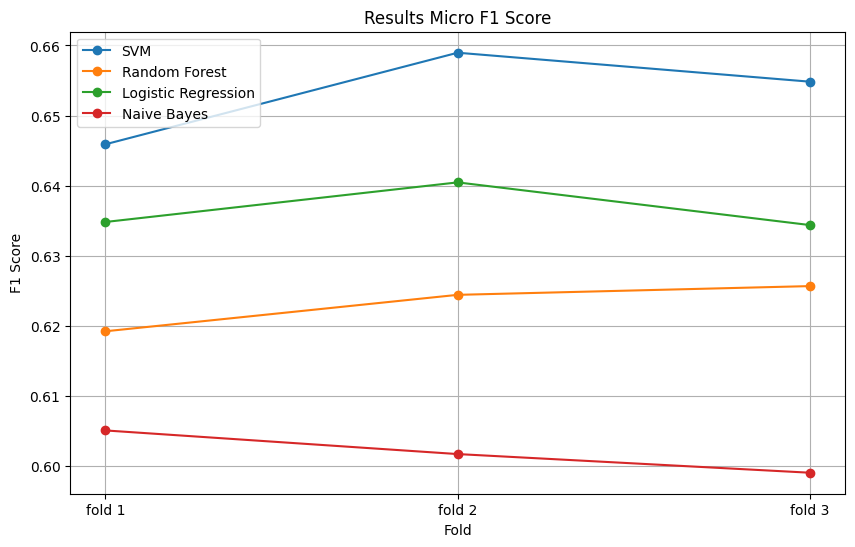

In [48]:
## Micro plot

plt.figure(figsize=(10, 6))

for column in metrics_micro.columns[1:5]:
    plt.plot(metrics_micro['folds'], metrics_micro[column], marker='o', label=column)

plt.title('Results Micro F1 Score')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

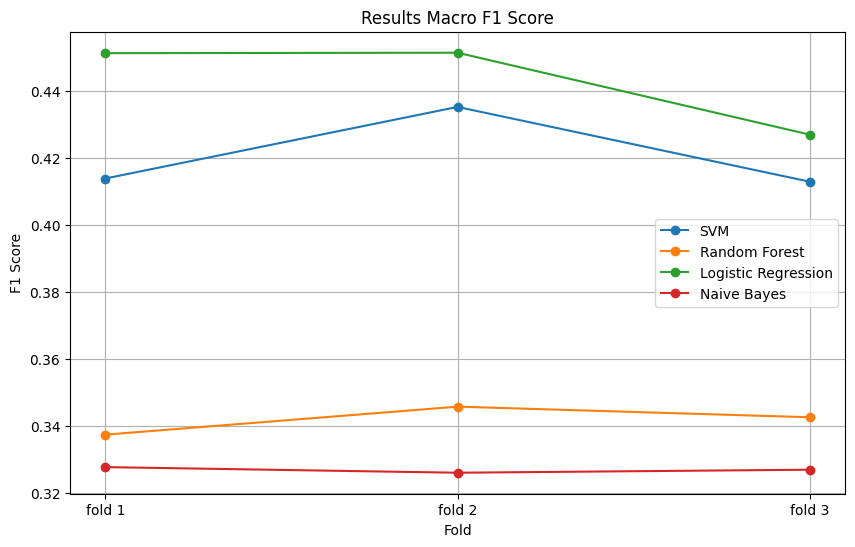

In [49]:
## Macro plot

plt.figure(figsize=(10, 6))

for column in metrics_macro.columns[1:5]:
    plt.plot(metrics_macro['folds'], metrics_macro[column], marker='o', label=column)

plt.title('Results Macro F1 Score')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
with open(path+'ml_metrics.csv', 'wb') as f:
    metrics_df.to_csv(f, index = False)

Both *SVM* and *Logistic Regression* perform quite similarly. For computational and training time issues, we choose *Logistic Regression* as the best classifier.

## **Final Evaluation**

We retrain the model and we test it.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(anime_df_genre['preprocessed_synopsis'],
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42)

vectorizer = TfidfVectorizer(max_features = 10000, min_df = 0.01, max_df = 0.99, ngram_range=(1,2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [52]:
clf = MultiOutputClassifier(LogisticRegression(solver = 'saga', max_iter=1000, tol = 1e-3,C=10, penalty = 'l2')).fit(X_train_vectorized, y_train)
y_pred = clf.predict(X_test_vectorized)

In [53]:
print(classification_report(y_pred,y_test, zero_division = 0))

              precision    recall  f1-score   support

           0       0.71      0.74      0.73      1292
           1       0.59      0.66      0.62      1186
           2       0.34      0.52      0.42       495
           3       0.54      0.71      0.62       330
           4       0.75      0.76      0.75      1535
           5       0.08      0.75      0.14         8
           6       0.10      0.32      0.15        44
           7       0.03      0.22      0.05         9
           8       0.32      0.56      0.41       212

   micro avg       0.58      0.69      0.63      5111
   macro avg       0.39      0.58      0.43      5111
weighted avg       0.63      0.69      0.65      5111
 samples avg       0.60      0.64      0.58      5111



In [ ]:
multilabel_binarizer.classes_

array(['Action and Adventure', 'Comedy and Romance', 'Drama and Mistery',
       'Erotica e Hentai', 'Fantasy and Supernatural',
       'Gourmet and Avant Garde', 'Horror and Suspense', 'Love',
       'Sport and Slice of Life'], dtype=object)

The classes represented by the binarizer are as follows:
* *Action and Adventure* represented by 0
* *Comedy and Romance* represented by 1
* *Drama and Mistery* represented by 2
* *Erotica and Hentai* represented by 3
* *Fantasy and Supernatural* represented by 4
* *Gourmet and Avant Garde* represented by 5
* *Horror and Suspense* represented by 6
* *Love* represented by 7
* *Sport and Slice of Life* represented by 8

# **Saving the models**

In [ ]:
with open(path + '/models/' + 'best_ml_model.pkl', 'wb') as f:
  pickle.dump(clf, f)

In [ ]:
with open(path + '/models/' + 'multilabel_binarizer.pkl', 'wb') as f:
  pickle.dump(multilabel_binarizer, f)

In [ ]:
with open(path + '/models/' + 'tfidf_vectorizer.pkl', 'wb') as f:
  pickle.dump(vectorizer, f)